In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.utils import ModelEmaV3
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

![Screenshot from 2025-03-01 04-05-24.png](<attachment:Screenshot from 2025-03-01 04-05-24.png>)
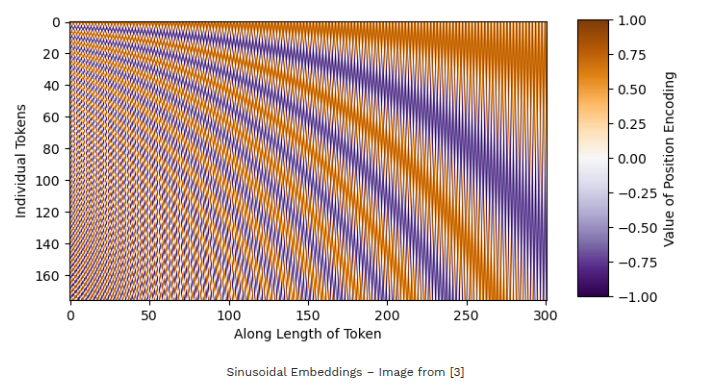

In [ ]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim:int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1), float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings
        
    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, C:int, num_groups:int, dropout_prob:float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size==3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size==3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)
        
    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], : , :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [ ]:
class Attention(nn.Module):
    def __init__(self, C:int, num_heads:int, dropout_prob:float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        
    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', k=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scale_dot_product_attention(q, k, v, is_casual=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

In [ ]:
class UnetLayer(nn.Module):
    def __init__(self, upscale:bool, attention:bool, num_groups:int, dropout_prob:float, C:int, num_heads:int):
        super().__init__()
        self.ResBlock1 = ResBlock(C, num_groups, dropout_prob)
        self.ResBlock2 = ResBlock(C, num_groups, dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, padding=1, stride=2)
        if attention:
            self.attention_layer = Attention(C, num_heads, dropout_prob)
    
    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

![Screenshot from 2025-03-01 04-04-32.png](<attachment:Screenshot from 2025-03-01 04-04-32.png>)
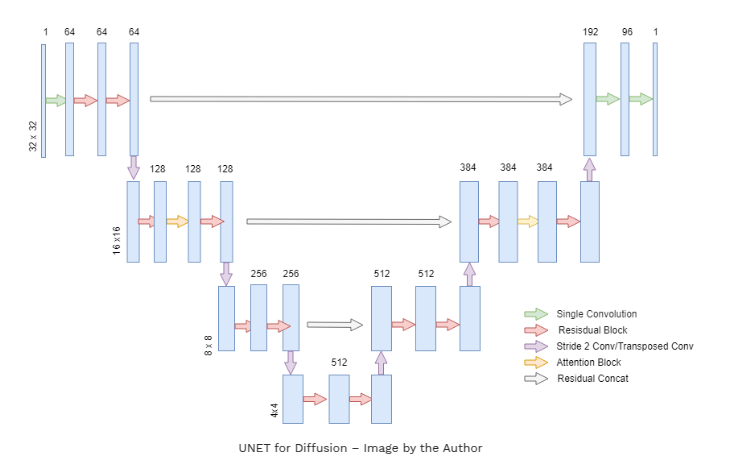

In [ ]:
class UNET(nn.Module):
    def __init__(self, 
                Channels: List = [64, 128, 256, 512, 512, 384],
                Attentions: List = [False, True, False, False, True, True],
                Upscales: List = [False, False, False, True, True, True],
                num_groups: int = 32,
                dropout_prob: float = 0.1,
                num_heads: int = 8,
                input_channels: int = 1,
                output_channels: int = 1,
                time_steps: int = 1000):
        
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2) + Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        
        for i in range(self.num_layers):
            layer = UnerLayer(
                upscale = Upscales[i],
                attention = Attentions[i],
                num_groups = num_groups,
                dropout_prob = dropout_prob,
                C = Channels[i],
                num_heads = num_heads
            )
            setattr(self, f'Layer_{i+1}', layer)
    
    
    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer_{i+1}')
            embeddings = self.embeddings(x, t)
            x, residual = layer(x, embeddings)
            residuals.append(residual)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer_{i+1}')
            x = torch.concat(layer(x, embeddings)[0], residuals.pop(), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [ ]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps:int = 1000):
        super().__init__()
        